In [1]:
import numpy as np
import pandas as pd

rng = np.random.default_rng(0)
from glmnet.cox import CoxFamily, CoxLM, CoxNet
from glmnet.glm import GLMControl
import rpy2
%load_ext rpy2.ipython

In [2]:
n, p = 100, 10
status = rng.choice([0, 1], size=n)
start = rng.integers(0, 5, size=n)
event = start + rng.integers(1, 5, size=n) 
event_data = pd.DataFrame({'event':event,
                           'status':status,
                           'start':start})
X = rng.standard_normal((n, p))
event_data

,event,status,start
0,3,1,2
1,5,1,3
2,3,1,1
3,2,0,1
4,7,0,3
...,...,...,...
95,8,1,4
96,5,0,1
97,6,0,4
98,5,0,1


## There are clearly lots of ties

In [3]:
np.unique(event).shape, n

((8,), 100)

In [4]:
%%R -i event,status,X,start -o C1,C2
library(survival)
Y = Surv(start, event, status)
M1 = coxph(Y ~ X, ties='breslow')
M2 = coxph(Y ~ X, ties='efron')
C1 = coef(M1)
C2 = coef(M2)

In [5]:
cox_fam1 = CoxFamily(start_col='start', tie_breaking='breslow')
G1 = CoxLM(family=cox_fam1, control=GLMControl(epsnr=1e-10))
np.linalg.norm(G1.fit(X, event_data).coef_ - C1) / np.linalg.norm(C1)

1.0921154605630758e-06

In [6]:
cox_fam2 = CoxFamily(start_col='start', tie_breaking='efron')
G2 = CoxLM(family=cox_fam2, control=GLMControl(epsnr=1e-10))
np.linalg.norm(G2.fit(X, event_data).coef_ - C2) / np.linalg.norm(C2)

2.7781670297805405e-06

In [7]:
np.linalg.norm(C1-C2) / np.linalg.norm(C1)

0.18687983413212678

In [8]:
G3 = CoxNet(family=cox_fam2)
G3.fit(X, event_data)

CoxNet(lambda_values=array([1.00000000e+00, 9.11162756e-01, 8.30217568e-01, 7.56463328e-01,
       6.89261210e-01, 6.28029144e-01, 5.72236766e-01, 5.21400829e-01,
       4.75081016e-01, 4.32876128e-01, 3.94420606e-01, 3.59381366e-01,
       3.27454916e-01, 2.98364724e-01, 2.71858824e-01, 2.47707636e-01,
       2.25701972e-01, 2.05651231e-01, 1.87381742e-01, 1.70735265e-01,
       1.55567614e-01, 1.41747416e-01, 1.29154967e-01, 1.17681195e-01,
       1.07226722e-01, 9.77009957e-02, 8.90215085e-02, 8.11130831e-02,
       7.39072203e-02, 6.73415066e-02, 6.13590727e-02, 5.59081018e-02,
       5.09413801e-02, 4.64158883e-02, 4.22924287e-02, 3.85352859e-02,
       3.51119173e-02, 3.19926714e-02, 2.91505306e-02, 2.65608778e-02,
       2.42012826e-02, 2.20513074e-02, 2.00923300e-02, 1.83073828e-02,
       1.66810054e-02, 1.51991108e-02, 1.38488637e-02, 1.26185688e-02,
       1.14975700e-02, 1.04761575e-02, 9.54548457e-03, 8.69749003e-03,
       7.92482898e-03, 7.22080902e-03, 6.57933225e-03, 5.99484250e-03,
       5.46227722e-03, 4.97702356e-03, 4.53487851e-03, 4.13201240e-03,
       3.76493581e-03, 3.43046929e-03, 3.12571585e-03, 2.84803587e-03,
       2.59502421e-03, 2.36448941e-03, 2.15443469e-03, 1.96304065e-03,
       1.78864953e-03, 1.62975083e-03, 1.48496826e-03, 1.35304777e-03,
       1.23284674e-03, 1.12332403e-03, 1.02353102e-03, 9.32603347e-04,
       8.49753436e-04, 7.74263683e-04, 7.05480231e-04, 6.42807312e-04,
       5.85702082e-04, 5.33669923e-04, 4.86260158e-04, 4.43062146e-04,
       4.03701726e-04, 3.67837977e-04, 3.35160265e-04, 3.05385551e-04,
       2.78255940e-04, 2.53536449e-04, 2.31012970e-04, 2.10490414e-04,
       1.91791026e-04, 1.74752840e-04, 1.59228279e-04, 1.45082878e-04,
       1.32194115e-04, 1.20450354e-04, 1.09749877e-04, 1.00000000e-04]), lambda_fractional=True, alpha=1.0, lower_limits=-inf, upper_limits=inf, penalty_factor=None, fit_intercept=False, standardize=True, family=CoxFamily(tie_breaking='efron', event_col='event', status_col='status', start_col='start'), control=GLMNetControl(thresh=1e-07, maxit=100000, big=9.9e+35, logging=False, mxitnr=25, epsnr=1e-06, fdev=1e-05), regularized_estimator=<class 'glmnet.cox.RegCoxLM'>)

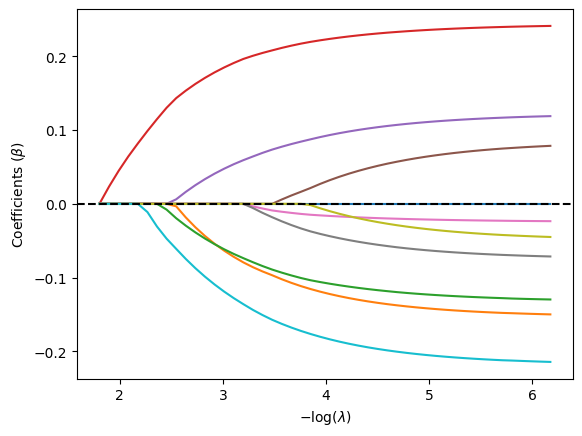

In [9]:
G3.plot_coefficients();

In [10]:
G3.cross_validation_path(X, event_data)

(          Cox Deviance  SD(Cox Deviance)
 lambda                                  
 0.164709      0.597598          0.100790
 0.150076      0.599924          0.102339
 0.136744      0.601433          0.104273
 0.124596      0.602860          0.106202
 0.113527      0.604640          0.108257
 0.103442      0.606281          0.110741
 0.094252      0.606453          0.113205
 0.085879      0.606824          0.115403
 0.078250      0.607247          0.117260
 0.071298      0.606857          0.119103
 0.064964      0.607280          0.121171
 0.059193      0.607515          0.123307
 0.053935      0.608255          0.125379
 0.049143      0.609742          0.127290
 0.044777      0.611545          0.129150
 0.040800      0.614024          0.131359
 0.037175      0.616567          0.133586
 0.033873      0.619329          0.135944
 0.030863      0.622629          0.138416
 0.028122      0.625898          0.140769
 0.025623      0.628889          0.143026
 0.023347      0.631636          0

<Axes: xlabel='$-\\log(\\lambda)$', ylabel='Cox Deviance'>

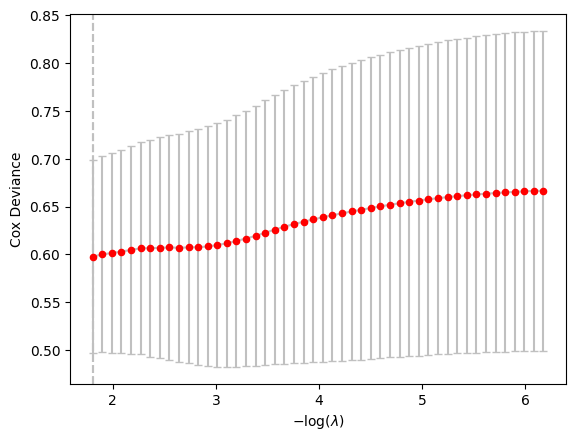

In [11]:
G3.plot_cross_validation()